In [46]:
# Import all necessery python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import requests as req
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from selenium import webdriver
import time
import geopy.distance
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import roman
import seaborn as sns
from fake_useragent import UserAgent

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from IPython.display import Image

sns.set()

%matplotlib inline

In [4]:
!ls

2013_movies.csv   Challenge 2.ipynb


In [180]:
df = pd.read_csv('2013_movies.csv')
df.head()

,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate
0,The Hunger Games: Catching Fire,130000000.0,424668047,Francis Lawrence,PG-13,146,2013-11-22 00:00:00
1,Iron Man 3,200000000.0,409013994,Shane Black,PG-13,129,2013-05-03 00:00:00
2,Frozen,150000000.0,400738009,Chris BuckJennifer Lee,PG,108,2013-11-22 00:00:00
3,Despicable Me 2,76000000.0,368061265,Pierre CoffinChris Renaud,PG,98,2013-07-03 00:00:00
4,Man of Steel,225000000.0,291045518,Zack Snyder,PG-13,143,2013-06-14 00:00:00


In [181]:
df = df.apply(pd.to_numeric, errors='ignore')
df['ReleaseDate'] = df['ReleaseDate'].apply(pd.to_datetime, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
Title                 100 non-null object
Budget                89 non-null float64
DomesticTotalGross    100 non-null int64
Director              96 non-null object
Rating                100 non-null object
Runtime               100 non-null int64
ReleaseDate           100 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 5.5+ KB


**Challenge 1**

Plot domestic total gross over time.

In [57]:
df_time = (df
    .groupby('ReleaseDate')['DomesticTotalGross']
    .agg('median')
    .reset_index()
          )
df_time.head()

,ReleaseDate,DomesticTotalGross
0,2013-01-04,34341945.0
1,2013-01-11,43021293.0
2,2013-01-18,71628180.0
3,2013-01-25,55703475.0
4,2013-02-01,66380662.0


Text(0.5,1,'Median domestic Total Gross of movies per release dates')

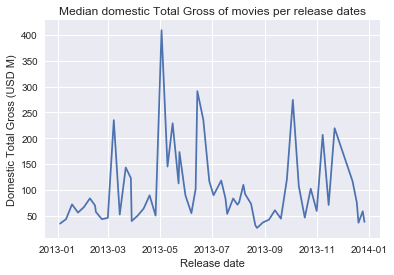

In [59]:
plt.plot(df_time['ReleaseDate'],df_time['DomesticTotalGross']/1000000)
plt.xlabel('Release date')
plt.ylabel('Domestic Total Gross (USD M)')
plt.title('Median domestic Total Gross of movies per release dates')

**Challenge 2**

Plot runtime vs. domestic total gross.

In [73]:
df_runtime = (df
             .groupby('Runtime')['DomesticTotalGross']
             .agg('median')
             .reset_index()
             )
df_runtime.head()

,Runtime,DomesticTotalGross
0,75,32244051.0
1,80,40041683.0
2,85,48244451.0
3,87,36076121.0
4,88,55703475.0


Text(0.5,1,'Median domestic Total Gross of movies per runtime')

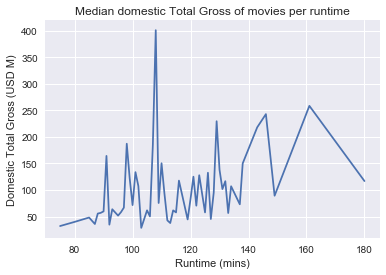

In [74]:
plt.plot(df_runtime['Runtime'],df_runtime['DomesticTotalGross']/1000000)
plt.xlabel('Runtime (mins)')
plt.ylabel('Domestic Total Gross (USD M)')
plt.title('Median domestic Total Gross of movies per runtime')

**Challenge 3**

Group your data by Rating and find the average runtime and domestic total gross at each level of Rating.

In [90]:
df_rating = (df
             .groupby('Rating')['DomesticTotalGross','Runtime']
             .agg({'Runtime':'mean', 'DomesticTotalGross':'mean'})
             .reset_index()
             )
df_rating['DomesticTotalGross'] = df_rating['DomesticTotalGross']/1000000
df_rating.head()

,Rating,Runtime,DomesticTotalGross
0,G,107.000000,268.492764
1,PG,99.933333,131.135716
2,PG-13,117.510638,111.449769
3,R,110.729730,69.892429


Text(0.5,1,'Average domestic Total Gross of movies per rating')

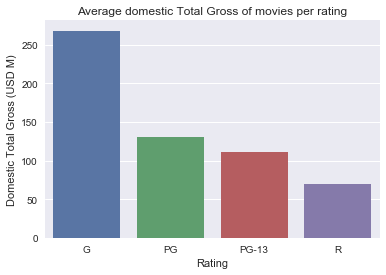

In [91]:
sns.barplot(x = 'Rating',y='DomesticTotalGross',data=df_rating);
plt.xlabel('Rating')
plt.ylabel('Domestic Total Gross (USD M)')
plt.title('Average domestic Total Gross of movies per rating')

Text(0.5,1,'Average runtime of movies per rating')

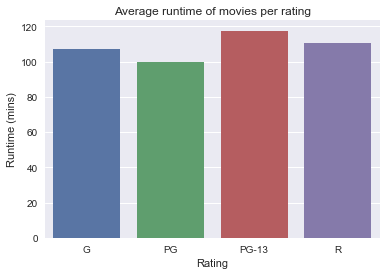

In [92]:
sns.barplot(x = 'Rating',y='Runtime',data=df_rating);
plt.xlabel('Rating')
plt.ylabel('Runtime (mins)')
plt.title('Average runtime of movies per rating')

**Challenge 4**

Make one figure with (N=the number of MPAA ratings there are) subplots, and in each plot the release date vs the domestic total gross.

In [89]:
df_ratingwithdate = (df
             .groupby(['Rating','ReleaseDate'])['DomesticTotalGross','Runtime']
             .agg({'Runtime':'mean', 'DomesticTotalGross':'mean'})
             .reset_index()
             )
df_ratingwithdate['DomesticTotalGross'] = df_ratingwithdate['DomesticTotalGross']/1000000
df_ratingwithdate.head()

,Rating,ReleaseDate,Runtime,DomesticTotalGross
0,G,2013-06-21,107.0,268.492764
1,PG,2013-02-15,89.0,57.012977
2,PG,2013-03-08,127.0,234.911825
3,PG,2013-03-22,98.0,187.168425
4,PG,2013-05-24,102.0,107.518682


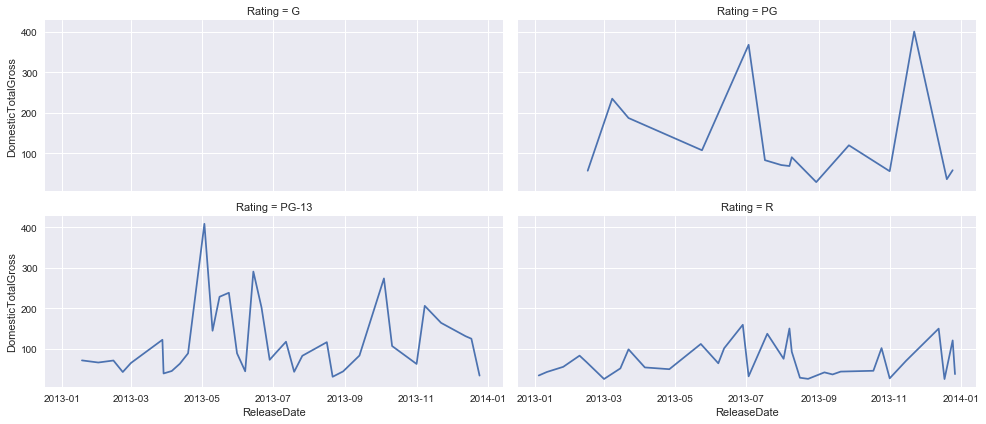

In [128]:
g = sns.FacetGrid(df_ratingwithdate, col='Rating',col_wrap=2,aspect=2.3,size=3)
g.map(plt.plot, 'ReleaseDate','DomesticTotalGross');

**Challenge 5**

What director in your dataset has the highest gross per movie?

In [129]:
df.head()

,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate
0,The Hunger Games: Catching Fire,130000000.0,424668047,Francis Lawrence,PG-13,146,2013-11-22
1,Iron Man 3,200000000.0,409013994,Shane Black,PG-13,129,2013-05-03
2,Frozen,150000000.0,400738009,Chris BuckJennifer Lee,PG,108,2013-11-22
3,Despicable Me 2,76000000.0,368061265,Pierre CoffinChris Renaud,PG,98,2013-07-03
4,Man of Steel,225000000.0,291045518,Zack Snyder,PG-13,143,2013-06-14


In [143]:
df_director = (df
              .groupby(['Director','Title'])['DomesticTotalGross']
              .agg('mean')
              .reset_index()
              .sort_values('DomesticTotalGross', ascending=False)
              )
df_director.head(1)

,Director,Title,DomesticTotalGross
27,Francis Lawrence,The Hunger Games: Catching Fire,424668047


**Challenge 6**

Bin your dataset into months and make a bar graph of the mean domestic total gross by month.  Error bars will represent the standard error of the mean.

Title of graph should include:  Mean Domestic Total Gross by Month in 2013

Topic for consideration:  what is the correct formula for the standard error of the mean?  Examine the error bars and see if they are "reasonable."

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
Title                 100 non-null object
Budget                89 non-null float64
DomesticTotalGross    100 non-null int64
Director              96 non-null object
Rating                100 non-null object
Runtime               100 non-null int64
ReleaseDate           100 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 5.5+ KB


In [204]:
df_monthly = (df
              .groupby(df.ReleaseDate.dt.month)['DomesticTotalGross']
              .agg('mean')
              .reset_index()
             )
df_monthly['DomesticTotalGross'] = df_monthly['DomesticTotalGross']/1000000
df_monthly['ReleaseDate'] = df_monthly['ReleaseDate'].apply(lambda x: str(x))
df_monthly.rename(columns = {'ReleaseDate':'Month'}, inplace=True)
df_monthly.replace({'1':'Jan','2':'Feb','3':'Mar','4':'Apr','5':'May','6':'Jun','7':'Jul','8':'Aug','9':'Sep','10':'Oct','11':'Nov','12':'Dec'}, inplace=True)
df_monthly

,Month,DomesticTotalGross
0,Jan,49.543237
1,Feb,67.386014
2,Mar,96.097096
3,Apr,60.940720
4,May,177.409720
5,Jun,150.650006
6,Jul,105.780722
7,Aug,68.531263
8,Sep,61.712314
9,Oct,115.027038


In [205]:
df['Month'] = df.ReleaseDate.dt.month
df['Month'] = df['Month'].apply(lambda x: str(x))
df.replace({'1':'Jan','2':'Feb','3':'Mar','4':'Apr','5':'May','6':'Jun','7':'Jul','8':'Aug','9':'Sep','10':'Oct','11':'Nov','12':'Dec'}, inplace=True)
df['DomesticTotalGross_millions'] = df['DomesticTotalGross']/1000000

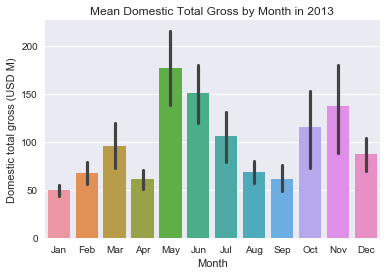

In [214]:
sns.barplot(x = 'Month',y='DomesticTotalGross_millions',
            data=df,order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
            ci=68,
            estimator=np.mean           
           );
plt.ylabel('Domestic total gross (USD M)')
plt.title('Mean Domestic Total Gross by Month in 2013')
plt.show()